<a href="https://colab.research.google.com/github/crazycroat/racunalni_vid_zeljko_krijan/blob/main/DIZAJN_I_OPTIMIZACIJA_CJELOVITOG_PIPELINEA_ZA_SEGMENTACIJU_%C5%BDLIJEZDANIH_STRUKTURA_U_HISTOLO%C5%A0KIM_SLIKAMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Uvoz biblioteka

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
import pandas as pd

plt.rcParams['figure.figsize'] = (6,4)

2. Učitavanje slike i maske

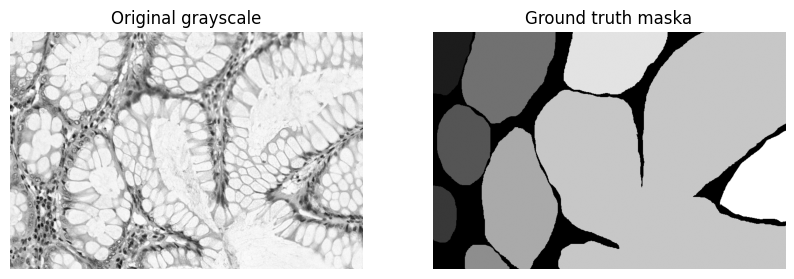

In [2]:
# Učitaj histološku sliku i masku
img = cv2.imread("slike/testA_1.bmp")
mask = cv2.imread("slike/testA_1_anno.bmp", cv2.IMREAD_GRAYSCALE)

# Pretvorba u grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(gray, cmap='gray'); plt.title("Original grayscale"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.title("Ground truth maska"); plt.axis('off')
plt.show()

3. Predobrada slike

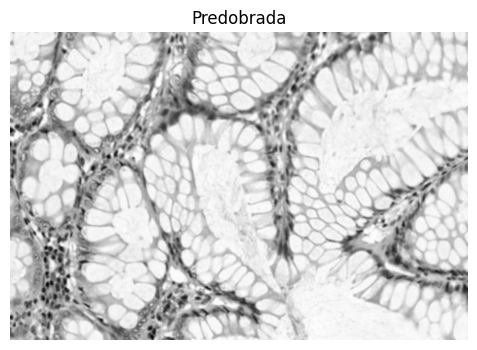

In [3]:
def preprocess(image):
    # Normalizacija intenziteta
    norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    # Gaussian filtriranje
    blur = cv2.GaussianBlur(norm, (5,5), 0)

    return blur

pre = preprocess(gray)

plt.imshow(pre, cmap='gray')
plt.title("Predobrada")
plt.axis('off')
plt.show()

4. Segmentacija (Otsu metoda)

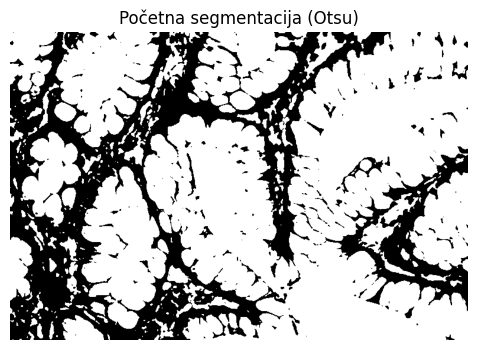

In [4]:
def segment(image):
    # Otsu binarizacija
    _, otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu

seg_initial = segment(pre)

plt.imshow(seg_initial, cmap='gray')
plt.title("Početna segmentacija (Otsu)")
plt.axis('off')
plt.show()

5. Postobrada (morfologija)

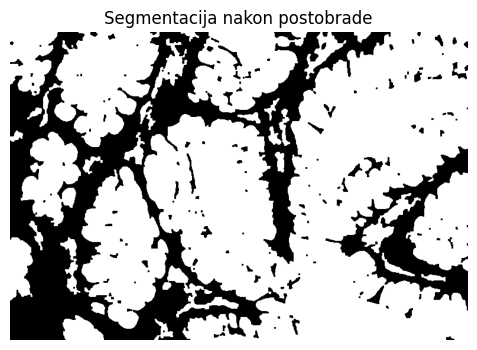

In [5]:
kernel = np.ones((3,3), np.uint8)

def postprocess(binary):
    # Opening (uklanjanje šuma)
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Closing (popunjavanje rupa)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    # Uklanjanje malih objekata
    cleaned = morphology.remove_small_objects(closed.astype(bool), min_size=200)
    cleaned = (cleaned * 255).astype(np.uint8)

    return cleaned

seg_final = postprocess(seg_initial)

plt.imshow(seg_final, cmap='gray')
plt.title("Segmentacija nakon postobrade")
plt.axis('off')
plt.show()

6. Evaluacija (Dice i IoU)

In [6]:
def dice_score(pred, gt):
    pred = pred > 0
    gt = gt > 0
    intersection = np.logical_and(pred, gt).sum()
    denom = pred.sum() + gt.sum()
    return 2 * intersection / denom if denom != 0 else 1.0

def iou_score(pred, gt):
    pred = pred > 0
    gt = gt > 0
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union if union != 0 else 1.0

dice_initial = dice_score(seg_initial, mask)
iou_initial = iou_score(seg_initial, mask)

dice_final = dice_score(seg_final, mask)
iou_final = iou_score(seg_final, mask)

df = pd.DataFrame({
    "Verzija": ["Početna segmentacija", "Nakon postobrade"],
    "Dice": [dice_initial, dice_final],
    "IoU": [iou_initial, iou_final]
})

df

,Verzija,Dice,IoU
0,Početna segmentacija,0.840488,0.724864
1,Nakon postobrade,0.848202,0.736416


7. Grafički prikaz metrika

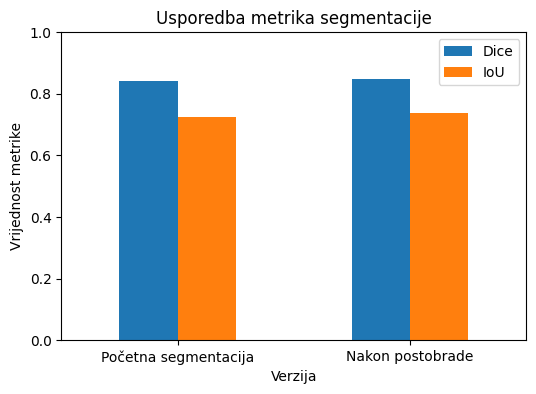

In [7]:
ax = df.plot(x="Verzija", y=["Dice", "IoU"], kind="bar", ylim=(0,1), rot=0)
ax.set_title("Usporedba metrika segmentacije")
ax.set_ylabel("Vrijednost metrike")
plt.show()

8. Vizualni prikaz svih koraka

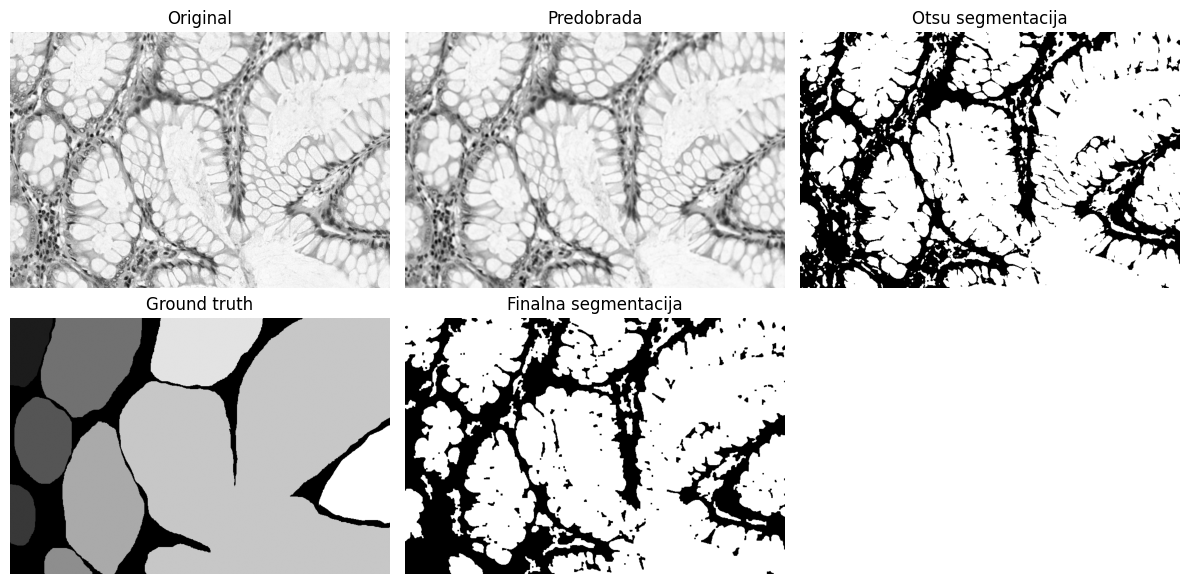

In [8]:
plt.figure(figsize=(12,6))

plt.subplot(2,3,1); plt.imshow(gray, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(pre, cmap='gray'); plt.title("Predobrada"); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(seg_initial, cmap='gray'); plt.title("Otsu segmentacija"); plt.axis('off')

plt.subplot(2,3,4); plt.imshow(mask, cmap='gray'); plt.title("Ground truth"); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(seg_final, cmap='gray'); plt.title("Finalna segmentacija"); plt.axis('off')

plt.tight_layout()
plt.show()